# Basics: Medical images
In this notebook, I am going to explore how medical images of the `.dicom` format are handeled in python. This is in preparation for working with the deepfake medical imaging data from 
the UCI machine learning repository.

For the whole notebook, I follow the code from Franklin Heng, found in [this medium blogpost.](https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed)

In [2]:
# Import the package
import numpy as np
import pydicom
from matplotlib import pyplot as plt

import os
import copy


# skimage image processing packages
# https://hengloose.medium.com/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

from mpl_toolkits.mplot3d.art3d import Poly3DCollection


### Functions to load the `.dicom` files

In [3]:
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

    
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

## Getting the data
I have mounted the drive directory from the UCI machine learning repo to my google drive, so I can work with it in google collab. below I specify the path to one patient.

In [4]:
path = '/content/drive/My Drive/Datasets/Tampered Scans/Experiment 1 - Blind/1003/'

Load the data

In [5]:
patient_dicom = load_scan(path)
patient_pixels = get_pixels_hu(patient_dicom)

Show one image to see if loading the data has worked

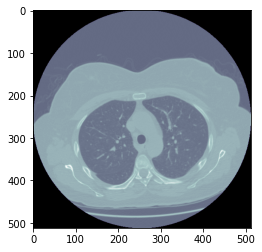

In [6]:
plt.imshow(patient_pixels[326], cmap=plt.cm.bone)


### Function to isolate the lung
The below functions are again taken fro mthe same medium blog post as above. We isolate the lung from the images, as the images portrait real and fake lung images.

In [7]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the patient
    # More resistant to “trays” on which the patient lays cutting   
    #  the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

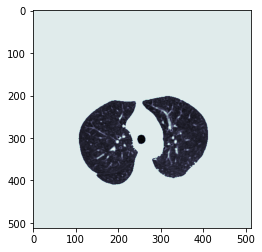

In [8]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,    
                  fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(patient_pixels,     
                       fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[326], cmap=plt.cm.bone)

## Interactive visualisation and 3D visualisation of the lungs
### Interactive

In [9]:
# slide through dicom images using a slide bar 
plt.figure(1)
def dicom_animation(x):
    plt.imshow(patient_pixels[x])
    return x
interact(dicom_animation, x=(0, len(patient_pixels)-1))

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=240, description='x', max=480), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation>

### 3D

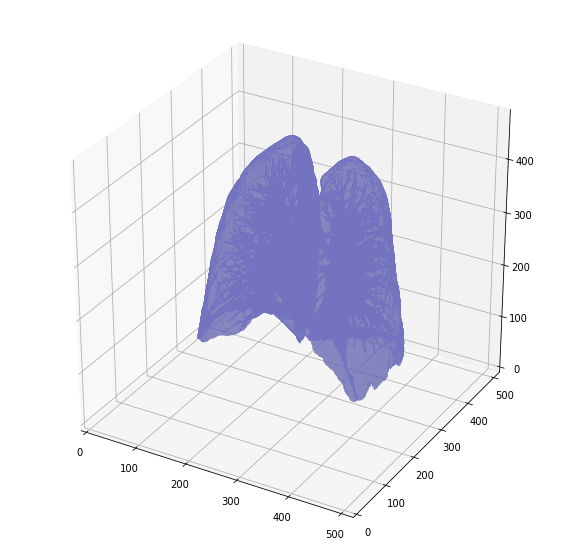

In [12]:
def plot_3d(image):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
# run visualization 
plot_3d(seg_lung_pixels)